In [1]:
import re
import pandas as pd
from konlpy.tag import Okt
from gensim import corpora, models

stopwords = [
    '은', '는', '이', '가', '을', '를', '에', '에서', '과', '와', '의', '로', '으로', '하다', '이다','한', '했다', '하고' ,'인','적','한','상'
    ,'게', '거', '말', '간', '축', '책', '작가', '이야기', '작품', '선', '란', '개', '다시', '독자', '베스트셀러', '정세랑', '김영하', '스', '대', '됭',
    '곤', '위', '된다', '지', '윤재', '출', '속', '소설', '장편소설', '자이니치', '사라마구'
    # 추가적인 불용어 추가
]

# 데이터 로드
data = pd.read_csv(r"광운대_전처리_완료.csv")  

# 전처리를 위한 토크나이저 생성
tokenizer = Okt()

# 전처리 함수 정의
def preprocess_text(text):
    tokens = tokenizer.morphs(text)  # 형태소 분석
    tokens = [re.sub('[\[\],\']', '', token) for token in tokens]  # '['와 ']' 사이의 문자 및 ',' 제거
    tokens = [token for token in tokens if token not in stopwords]  # 불용어 제거
    tokens = [token for token in tokens if token]  # Remove empty tokens
    # 추가적인 전처리 작업 수행
    return tokens

In [2]:
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
import nltk

In [3]:
# 텍스트 전처리
data['preprocessed'] = data['책소개'].apply(preprocess_text) 

In [4]:
word2vec_model = Word2Vec(data['preprocessed'], min_count=1)

dictionary = Dictionary()
dictionary.doc2bow(word2vec_model.wv.index_to_key, allow_update=True)

# 단어 사전 및 문서-단어 행렬 생성
# dictionary = corpora.Dictionary(data['preprocessed'])
corpus = [dictionary.doc2bow(doc) for doc in data['preprocessed']]

In [5]:
# LDA 모델 훈련
num_topics = 5 # 토픽 개수
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# 토픽별 단어 출력
for topic_idx in range(num_topics):
    print(f"토픽 {topic_idx+1}:")
    words = lda_model.show_topic(topic_idx, topn=10)
    for word, prob in words:
        print(f"{word}: {prob:.4f}")
    print() 

토픽 1:
저자: 0.0077
기업: 0.0067
대한: 0.0053
돈: 0.0053
세계: 0.0053
내용: 0.0044
분야: 0.0044
가난한: 0.0039
질문: 0.0039
투자: 0.0034

토픽 2:
문제: 0.0164
하였다: 0.0117
하여: 0.0108
시험: 0.0096
출제: 0.0090
기출: 0.0079
있도록: 0.0079
편의점: 0.0068
설명: 0.0062
학습: 0.0059

토픽 3:
잡초: 0.0111
지능: 0.0099
인공: 0.0078
역사: 0.0056
김대식: 0.0056
세계: 0.0050
뇌: 0.0050
대한: 0.0040
강의: 0.0039
과학: 0.0039

토픽 4:
능력: 0.0061
공정: 0.0052
인가: 0.0043
존재: 0.0043
판례: 0.0042
대통령: 0.0042
상황: 0.0042
주의: 0.0042
내용: 0.0037
삶: 0.0033

토픽 5:
국어: 0.0068
이해: 0.0056
중세: 0.0056
감정: 0.0050
사랑: 0.0044
서점: 0.0044
하여: 0.0041
새로운: 0.0039
변화: 0.0037
지문: 0.0035



In [9]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(model=lda_model, texts=data['preprocessed'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("일관성 점수:", coherence_score)

일관성 점수: 0.4078078075207717


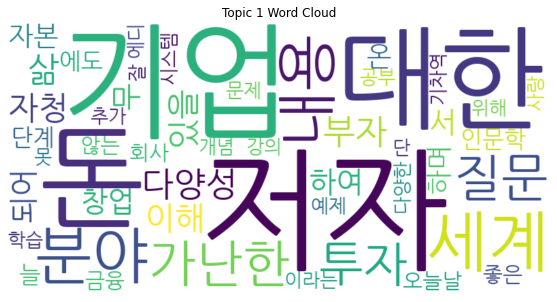

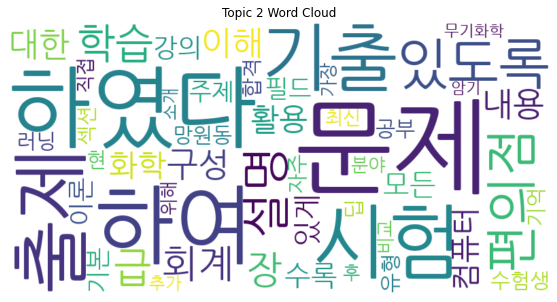

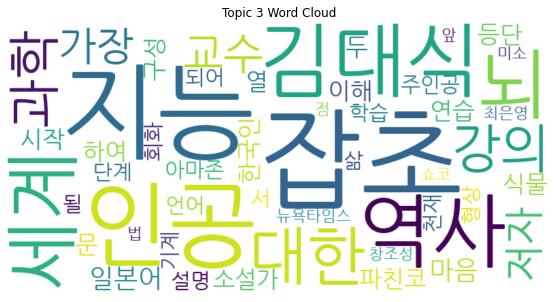

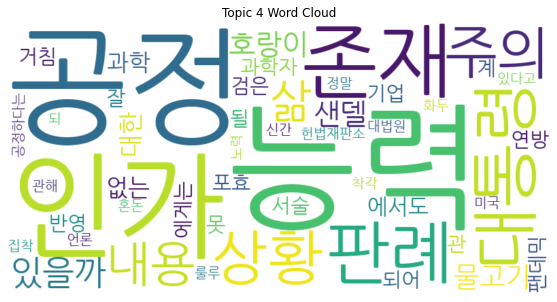

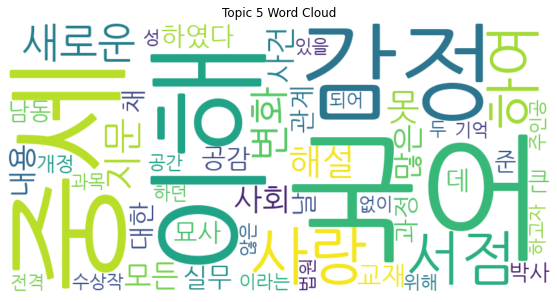

In [8]:
# 워드클라우드 코드 (각자 조정)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Generate word cloud for each topic
for topic_idx in range(num_topics):
    topic_words = lda_model.show_topic(topic_idx, topn=50)
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='NanumGothic.ttf').generate_from_frequencies(dict(topic_words))
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx+1} Word Cloud")
    plt.axis('off')
    plt.show()